In [1]:
from __future__ import division

import os
import pandas as pd                     # library to handle data even from spreadsheets 
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as mticker

import scipy.integrate as integrate
from scipy import interpolate
from scipy.interpolate import griddata  # useful for not-regular grid points
import scipy.special as bessel
import scipy.optimize as opt
from scipy.optimize import curve_fit

import sys
import pylab
import time
from tqdm.notebook import tqdm

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [3]:
def plot_cosmetics_single():
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.8, width=1.2, labelsize=18)
    ax.tick_params(direction='in', axis='both', which='minor', length=3.3, width=1.2, labelsize=18)
    ax.xaxis.set_tick_params(pad=7)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 15
    
    
def plot_cosmetics_multi():
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.8, width=1.2, labelsize=20)
    ax.tick_params(direction='in', axis='both', which='minor', length=3.3, width=1.2, labelsize=20)
    ax.xaxis.set_tick_params(pad=10)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 10

In [4]:
########################################################
# CONSTANTS: physical constants and conversion factors #
########################################################

pc_mt = 3.0857e+16              
pc_cm = 3.0857e+18              
m_to_pc = pow(pc_mt,-1)         
cm_to_pc = 3.24e-19             
conv_factor_GeV_to_erg = 0.00160218   
conv_factor_erg_to_GeV = 624.151
conv_factor_yr_to_sec = 31.56e+6
conv_GeV_g = 1.78e-24

m_p = 0.939                     # proton mass, in [GeV/c^2]
m_e = 0.000510998918            # electron mass, in [GeV/c^2]
c = 2.99e+10                    # speed of light, in [cm sec^{-1}]
c_pcSec = c * cm_to_pc          # same, in [pc sec^{-1}]

<hr>

# <center> Plasma parameters

$$
\begin{aligned}
&\bullet \; \; x_c \equiv \left( \frac{6 \rho M_A^2 L_{\mathrm{inj}} v_A}{\eta_0} \right)^{2/3} \\
&\bullet \; \; \rho = n_{\mathrm{ISM}} \cdot m_p, \qquad \eta_0 = 6 \cdot 10^{3} \, \left( \frac{37}{\mathrm{ln} \, \Lambda} \right) \left( \frac{T_{\mathrm{ISM}}}{10^8 \, \mathrm{K}} \right)^{5/2} \frac{\mathrm{g}}{\mathrm{cm \cdot s}} \; \left( \mathrm{Spitzer} \, 1962 \right), \qquad \mathrm{ln} \, \Lambda \equiv \mathrm{ln} \, \left( \frac{b_{\mathrm{max}}}{b_{\mathrm{min}}} \right) \simeq \mathrm{ln} \, \left( \frac{\lambda_D}{b_{\mathrm{min}}} \right), \, b_{\mathrm{min}} \approx 8.63 \cdot 10^{-8} \left( \frac{10^4 \, \mathrm{K}}{T_{\mathrm{ISM}}} \right) \, \mathrm{cm} \\
&\bullet \; \; \lambda_D \approx 0.95 \cdot 10^5 \cdot \left( \frac{T}{10^6 \, \mathrm{K}} \right)^{1/2} \left( \frac{10^{-3} \, \mathrm{cm}^{-3}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm} \\
&\bullet \; \; \beta = 3.3 \cdot \left( \frac{3 \, \mu\mathrm{G}}{B_{\mathrm{Cyg}}} \right)^2 \left( \frac{n_{\mathrm{ISM}}}{1 \, \mathrm{cm^{-3}}} \right) \left( \frac{T_{\mathrm{ISM}}}{10^4 \, \mathrm{K}} \right) \\
&\bullet \; \;  v_A = 6.27 \cdot 10^5 \, \left( \frac{B_{\mathrm{Cyg}}}{3 \, \mu\mathrm{G}} \right) \left( \frac{1 \, \mathrm{cm^{-3}}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm \cdot s^{-1}}
\end{aligned}
$$

<hr>

# <center>Truncation Scale   

#### Reference: [Petrosian $et \;al.$, ApJ 644, 603 (2006)](https://ui.adsabs.harvard.edu/abs/2006ApJ...644..603P/abstract "Open in ADS database") <br>

### Collisionless damping:

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \frac{4 \, M_A^4 \, \gamma \, \xi^2}{\pi \, \beta \, (1 - \xi^2)^2} \, e^{\frac{2}{\beta \, \gamma \, \xi^2}}\\[10pt]
&\gamma = \frac{m_p}{m_e}, \; \beta = \frac{P_g}{P_B}
\end{align}$$

### Collisional damping (viscous/Coulomb):

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \begin{cases}
    x_c \, (1 - \xi^2)^{-2/3} & \beta \ll 1\\
    x_c \, (1 - 3 \, \xi^2)^{-4/3} & \beta \gg 1
  \end{cases}\\[10pt]
&x_c =  \left( \frac{6 \, \rho \, \delta V^2 \, L_{\mathrm{inj}}}{\eta_0 \, v_A} \right)^{2/3} = \left( \frac{6 \, \rho \, M_A^2 \, L_{\mathrm{inj}} \, v_A}{\eta_0} \right)^{2/3}
\end{align}$$

<hr>

In [5]:
###################
### Environment ###
###################

#case_region = 'Halo'
case_region = 'Disk'

################################
### Environmental parameters ###
################################

gamma_ratio = m_p/m_e
B_field = 10.         # magnetic field, in [muGauss]
L_inj = 10.           # in [pc]
M_A = 1.              # Alfvénic Mach Number

if case_region == 'Halo':
    n_ISM = 1.e-3         # density of the environment, in [cm^{-3}]
    T_ISM = 1.e6          # in [K]
else:
    n_ISM = 1.e-1         # density of the environment, in [cm^{-3}]
    T_ISM = 5.e3          # in [K]

    
###################################
### Alfvénic turbulence scaling ###
###################################

AlfvTurbScal = 'GS95' # if not specified default is 'GS95'

###################################
### Shape of resonance function ###
###################################

ResFuncShape = 'Gaussian' #'BreitWigner' # if not specified default is 'Gaussian'

##########################
### Derived quantities ###
##########################

v_A = 6.27e5 * (B_field / 3.) * (1. / n_ISM)**(1/2)                       # in [cm sec^{-1}]
v_A_pcSec = v_A * cm_to_pc                                                # in [pc sec^{-1}]
rho = n_ISM * (m_p * conv_GeV_g)
Debye_length = 0.95e5 * (T_ISM / 1.e6)**(1/2) * (1.e-3 / n_ISM)**(1/2)    # in [cm]

b_min = 8.63e-8 * (1.e4 / T_ISM)                                          # in [cm]
ln_Lambda = np.log(Debye_length / b_min)
eta_0 = 6.e3 * (37 / ln_Lambda) * (T_ISM / 1.e8)**(5/2)                   # in [g cm^{-1} s^{-1}]


x_c = ( (6 * rho * M_A**2 * (L_inj*pc_cm) * v_A) / (eta_0) )**(2/3)
beta_plasma = 3.3 * (3. / B_field)**2 * (n_ISM / 1.) * (T_ISM / 1.e4)
#####


print(f'We are computing D(E) in the {case_region}.\n')
print(f'density of the ISM: n = {n_ISM} [cm^(-3)] -> rho = {rho} [g]')
print(f'temperature of the ISM: T = {T_ISM} [K]')
print(f'Alfvén speed: v_A = {v_A / 1.e5} [km s^(-1)]')
print(f'plasma beta = {beta_plasma}')
if case_region == 'Disk':
    print(f'log of the Coulomb lambda: ln_Lambda = {ln_Lambda}')
    print(f'x_c = {x_c}')

We are computing D(E) in the Disk.

density of the ISM: n = 0.1 [cm^(-3)] -> rho = 1.67142e-25 [g]
temperature of the ISM: T = 5000.0 [K]
Alfvén speed: v_A = 66.09160309751913 [km s^(-1)]
plasma beta = 0.01485
log of the Coulomb lambda: ln_Lambda = 22.0821774526117
x_c = 1098163.8954614


In [6]:
############################
### Numerical Parameters ###
############################

num_alpha = 250          # number of points in wave pitch-angle

length_mu_array = 250    # number of points in CR pitch-angle array
mu_array_min = 0.        # min value of CR pitch-angle array
mu_array_max = 0.999     # max value of CR pitch-angle array (warning: mu=1 is singular)

#length_energy_array = 20  # number of points in CR energy

#max_kL = L_inj / Larmor_radius(1.e-2, B_field)[1]    # maximum kL, resonating with 10^{-2}GeV CRs
max_kL = 1e+15        # max k*L value used to compute spectra
pointsPerDecade = 25  # for the integrals over the turbulence

log_p_CR_min = 0   # min p_CR in log-scale [GeV/c]
log_p_CR_max = 8   # max p_CR in log-scale [GeV/c]
num_log_p_CR = 32  # number of points in p_CR (equally spaced in log-scale)

log_ell_inverse_min = 1
log_ell_inverse_max = 16
num_log_ell_inverse = 700

########################
### Generating grids ###
########################

alpha = np.linspace(start = 0., stop = 90., num = num_alpha)    # array with the wave pitch-angle in degrees
cosAlpha = np.linspace(start = 0., stop = 1., num = num_alpha)  # array with the cosine of the wave pitch-angle (= k_para/k = xi)

p_CR = np.logspace(start=log_p_CR_min,stop=log_p_CR_max, num=num_log_p_CR)  # array with the CR momentum in GeV/c    
#p_CR = np.logspace(start = 0., stop = 5., num = length_energy_array)      # CR momentum, in [GeV/c]

ell_inverse = np.logspace(start=1., stop=log_ell_inverse_max, num=num_log_ell_inverse)

mu_array = np.linspace(start=mu_array_min, stop=mu_array_max, num=length_mu_array)   # array with the CR pitch-angle

xPara_array = np.logspace(start=0, stop=np.log10( max_kL ), num=pointsPerDecade*round(np.log10(max_kL)) )   # x_para = k_para*L
if (M_A <= 1.):
  xPerp_array = np.logspace(start=np.log10(M_A**(-2.)), stop=np.log10(max_kL), num = pointsPerDecade*round(np.log10(max_kL)) )  # x_perp = k_perp*L
else:
  xPerp_array = np.logspace(start=np.log10(M_A**3), stop=np.log10(max_kL), num=pointsPerDecade*round(np.log10( max_kL)) )
    
#####################
### Plot settings ###
#####################

path_plots = '/Users/sscerr/Documents/CR_project/DiffCoeffMHD_dev-branch/Plots/'  # path to save plots


In [7]:

p_CR_chosen = [1.e2, 1.e4]  # in [GeV]
indx_p_CR = [np.argmin( abs(p_CR - p_CR_chosen[i]) ) for i in range(len(p_CR_chosen))]


def Larmor_radius(p_, B_):
    # with p in [GeV] and B in [muG], the result is in [cm], and [pc]
    return 3.31e+12 * (p_ / 1.) * (1. / B_), 3.31e+12 * (p_ / 1.) * (1. / B_) * cm_to_pc


def LarmorToMomentum(r_L_, B_):
    # with r_L in [cm] and B in [muG], the result is in [GeV]
    return 3.021e-13 * (r_L_ / 1.) * (B_ / 1.)



kL_list = [L_inj / ell_inverse[ik] for ik in range(len(ell_inverse))]
indx_result_100GeV = np.argmin( abs(Larmor_radius(p_CR[indx_p_CR[0]], B_field)[1] - kL_list) )
indx_result_10TeV = np.argmin( abs(Larmor_radius(p_CR[indx_p_CR[1]], B_field)[1] - kL_list) )


print(f'indx 100GeV: {indx_result_100GeV}, indx 10TeV: {indx_result_10TeV}')
print(f'kL (100GeV) = {ell_inverse[indx_result_100GeV]}')

indx 100GeV: 229, indx 10TeV: 144
kL (100GeV) = 820659.6678933188


I am ignoring the warnings, due to the singularity of the functions.



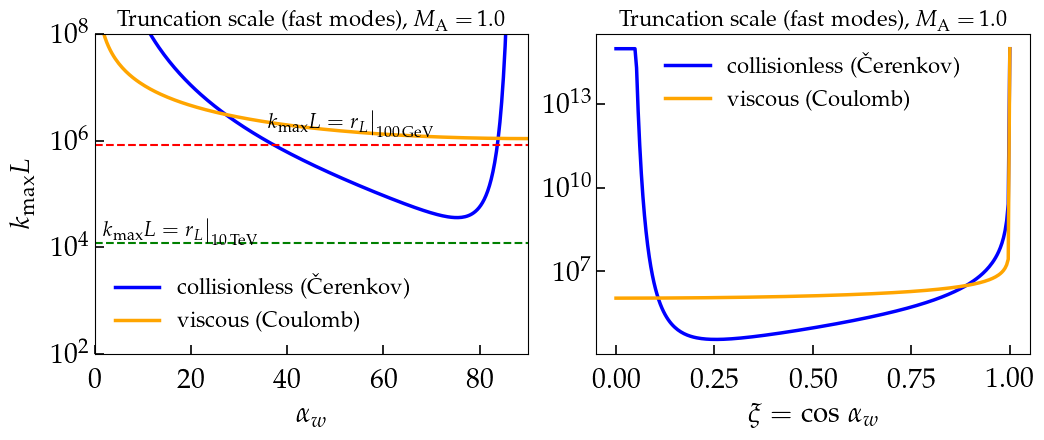

In [8]:
##################################################
### Calculate the truncation scale for damping ###
##################################################

import warnings
warnings.filterwarnings('ignore')
print('I am ignoring the warnings, due to the singularity of the functions.')
print('')


# collisionless
def kmaxL_coll( alpha_ ):
    numerator = 4. * M_A**4 * gamma_ratio * ( np.cos( np.radians(alpha_) ) )**2
    denominator = np.pi * beta_plasma * ( np.sin( np.radians(alpha_) ) )**4
    exp = np.exp( 2. / ( beta_plasma * gamma_ratio * ( np.cos( np.radians(alpha_) ) )**2 ) )
    return numerator / denominator * exp

def kmaxL_coll_xi( cosAlpha_ ):
    numerator = 4. * M_A**4 * gamma_ratio * ( cosAlpha_ )**2
    denominator = np.pi * beta_plasma * ( 1 - cosAlpha_**2 )**2
    exp = np.exp( 2. / ( beta_plasma * gamma_ratio * ( cosAlpha_ )**2 ) )
    return min(max_kL, numerator / denominator * exp)


# collisional (viscous)
def kmaxL_visc( alpha_ ):
    return x_c * ( np.sin( np.radians(alpha_) ) )**(-4/3)

def kmaxL_visc_xi( cosAlpha_ ):
    return min(max_kL, x_c * ( 1 - cosAlpha_**2 )**(-2/3))



plt.figure(figsize=(10.5, 4.5))
plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.plot(alpha, kmaxL_coll(alpha), lw=2.5, color='blue', label='collisionless (\\v{Cerenkov})')
plt.plot(alpha, kmaxL_visc(alpha), lw=2.5, color='orange', label='viscous (Coulomb)')
plt.axis([0.,90., 1.e2,1.e8])
plt.axhline(y=ell_inverse[indx_result_100GeV], ls='--', lw=1.5, color='red')
plt.axhline(y=ell_inverse[indx_result_10TeV], ls='--', lw=1.5, color='green')
plt.text(0.4, 0.703, '$k_{\mathrm{max}}L = r_L \\big|_{100 \, \mathrm{GeV}}$', fontsize=15, transform = plt.gca().transAxes)
plt.text(0.02, 0.366, '$k_{\mathrm{max}}L = r_L \\big|_{10 \, \mathrm{TeV}}$', fontsize=15, transform = plt.gca().transAxes)
plt.title('Truncation scale (fast modes), $M_{\mathrm{A}} = \,$' + str(M_A), fontsize=16, loc='center', pad=None)
plt.xlabel('$\\alpha_w$',fontsize=20)
plt.ylabel('$k_\mathrm{max}L$',fontsize=20)
plt.yscale('log')
plt.legend(fontsize=16, frameon=False, loc='best')


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.plot(cosAlpha, [kmaxL_coll_xi(i) for i in cosAlpha], lw=2.5, color='blue', label='collisionless (\\v{Cerenkov})')
plt.plot(cosAlpha, [kmaxL_visc_xi(i) for i in cosAlpha], lw=2.5, color='orange', label='viscous (Coulomb)')
plt.title('Truncation scale (fast modes), $M_{\mathrm{A}} = \,$' + str(M_A), fontsize=16, loc='center', pad=None)
plt.xlabel('$\\xi = \mathrm{cos} \; \\alpha_w$',fontsize=20)
plt.yscale('log')
plt.legend(fontsize=16, frameon=False, loc='best')
plt.tight_layout()


<hr>

# <center> Resonance functions

## General expressions

In the following:

- $\sigma\in\{\mathrm{A}, \mathrm{F}\}$ is the mode index.
- $M_\mathrm{A}^2 \equiv \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2}$ is the Alfvénic Mach number of the turbulent fluctuations (at injection scales).

### (I) Gaussian distribution (due to variation in magnetic-field modulus)

#### Reference: [Yan & Lazarian, ApJ 673, 942 (2008)](https://ui.adsabs.harvard.edu/abs/2008ApJ...673..942Y/abstract "Open in ADS database")  

(note the factor 2 missing in YL08)

$$
\mathcal{R}_n^\sigma \left( k_\parallel v_\parallel - \omega_\sigma + n\Omega \right) = \frac{\sqrt{\pi}}{\sqrt{2 M_\mathrm{A}} \, |k_\parallel| v_\perp} \cdot \mathrm{exp} \left[ { -\frac{ \left(k_\parallel v_\parallel - \omega_\sigma + n\Omega \right)^2 }{2 M_\mathrm{A} k_\parallel^2 v_\perp^2 } } \right] 
$$

### (II) Breit-Wigner distribution (due to Lagrangian correlation time of turbulence)

#### Reference: [Giacinti & Kirk, ApJ 835, 258 (2017)](https://ui.adsabs.harvard.edu/abs/2017ApJ...835..258G/abstract "Open in ADS database")

$$
\mathcal{R}_n^\sigma \left( k_\parallel v_\parallel - \omega + n\Omega \right) = \frac{ (\tau_\mathrm{nl}^\sigma)^{-1} }{ (k_\parallel v_\parallel - \omega + n\Omega)^2 + (\tau_\mathrm{nl}^\sigma)^{-2} }
$$

<br>

## Relevant contributions and suitable formulation for each mode

### <u>Fast modes</u>: 

- relevant contributions: $n=0,\pm1$ 

- suitable variables: ($x$, $\xi$) 

where $x=kL$ and $\xi=k_\|/k=\cos(\alpha_w)$

The linear frequency of the fast mode in the low-$\beta$ limit is $\omega_\mathrm{F}\approx k v_\mathrm{A}$.


#### (I) Gaussian distribution

<!--
$$
\begin{aligned}
&\mathcal{R}_n \left( k_\parallel, \Omega \right) = \frac{\sqrt{\pi}}{\sqrt{2} \, |k_\parallel| v_\perp \left( \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2} \right)^{1/4}} \cdot \mathrm{exp} \left[ { -\frac{ \left(k_\parallel v_\parallel - \omega \pm n\Omega \right)^2 }{2 k_\parallel^2 v_\perp^2 \left( \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2} \right)^{1/2} } } \right] =  
\begin{cases}
\mathcal{R}_0 = \frac{L \sqrt{\pi}}{\sqrt{2} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2} M_A^{1/2}} \cdot e^{ -\frac{\left( \mu \, - \, \frac{v_A}{\xi v_{\mathrm{CR}}} \right)^2}{2 (1 - \mu^2)M_A}  } & n=0\\[6pt]
\mathcal{R}_{\pm 1} = \frac{L \sqrt{\pi}}{\sqrt{2} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2} M_A^{1/2}} \cdot e^{ -\frac{\left( \mu \, \pm \, \frac{1}{x \xi R} \right)^2}{2 (1 - \mu^2)M_A}  } & n=\pm 1
&M_\mathrm{A}^2 \equiv \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2}
\end{cases}\\[10pt]
\end{aligned}
$$
-->
$$
\mathcal{R}_0^\mathrm{F} = \frac{L \sqrt{\pi}}{\sqrt{2 M_\mathrm{A}} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2}} \cdot e^{ -\frac{\left( \mu \, - \, \frac{v_A}{\xi v_{\mathrm{CR}}} \right)^2}{2 M_\mathrm{A} (1 - \mu^2)}  } \qquad\,(n=0)
$$

$$
\mathcal{R}_{\pm 1}^\mathrm{F} \simeq \frac{L \sqrt{\pi}}{\sqrt{2 M_\mathrm{A}} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2}} \cdot e^{ -\frac{\left( \mu \, \pm \, \frac{1}{x \xi R} \right)^2}{2 M_\mathrm{A} (1 - \mu^2)}  } \qquad\,(n=\pm 1)
$$  

#### (II) Breit-Wigner distribution 

We employ $\tau_\mathrm{nl}^\mathrm{F}\sim L\, v_\mathrm{A}/ (k^{1/2} \delta u_L) = \tau_{\mathrm{A},L}\, M_\mathrm{A}^{-2}\,(kL)^{-1/2}$ as the nonlinear timescale ("eddy-turnover time") for the cascade of fast modes; $\delta u_L$ and $\tau_{\mathrm{A},L}=L/v_\mathrm{A}$ are the turbulent-fluctuation level and Alfvénic time at injection scale $L$, respectively (see [Cho & Lazarian, PRL 88, 245001 (2002)](https://ui.adsabs.harvard.edu/abs/2002PhRvL..88x5001C/abstract "Open in ADS database")).

$$
\mathcal{R}_0^\mathrm{F} = \frac{L}{v_\mathrm{A}}\frac{M_\mathrm{A}^{-2} x^{-1/2}}{1 + M_\mathrm{A}^{-4}x\left(\mu\,\xi\,\frac{v_\mathrm{CR}}{v_\mathrm{A}}-1\right)^2} \qquad\,(n=0)
$$

$$
\mathcal{R}_{\pm 1}^\mathrm{F} \simeq \frac{L}{v_\mathrm{A}}\frac{M_\mathrm{A}^{-2} x^{-1/2}}{1 + M_\mathrm{A}^{-4}x\frac{v_\mathrm{CR}^2}{v_\mathrm{A}^2}\left(\mu\,\xi + \frac{n}{x\,R}\right)^2} \qquad\,(n=\pm 1)
$$  


### <u>Alfvén modes</u>

- relevant contributions: $n=\pm1$ 

- suitable variables: ($x_\parallel$, $x_\perp$) 

where $x_\parallel=k_\parallel L$ and $x_\perp=k_\perp L$

The linear frequency of the Alfvén mode is $\omega_\mathrm{A}= k_\parallel v_\mathrm{A}$.

#### (I) Gaussian distribution

$$
\begin{aligned}
\mathcal{R}_{\pm 1}^\mathrm{A}\simeq \frac{L \sqrt{\pi}}{\sqrt{2 M_\mathrm{A}} |x_\parallel| v_{\mathrm{CR}} (1 - \mu^2)^{1/2}} \cdot e^{ -\frac{\left( \mu \, \pm \, \frac{1}{x_\parallel R} \right)^2}{2 M_\mathrm{A} (1 - \mu^2)}  }
\end{aligned}
$$

#### (II) Breit-Wigner distribution

We employ $\tau_\mathrm{nl}^\mathrm{A}\sim L^{1/3}/ (k_\perp^{2/3} v_\mathrm{A}) = \tau_{\mathrm{A},L}\, M_\mathrm{A}^{-4/3}\,(k_\perp L)^{-2/3}$ as the nonlinear timescale ("eddy-turnover time") for the cascade of Alfvénic modes, where $\tau_{\mathrm{A},L}=L/v_\mathrm{A}$ is the Alfvénic time at injection scale $L$ (see [Goldreich & Sridhar, ApJ 438, 736 (1995)](https://ui.adsabs.harvard.edu/abs/1995ApJ...438..763G/abstract "Open in ADS database")).

$$
\mathcal{R}_{\pm 1}^\mathrm{A} \simeq \frac{L}{v_\mathrm{A}}\frac{M_\mathrm{A}^{-4/3} x_\perp^{-2/3}}{1 + \frac{v_\mathrm{CR}^2}{v_\mathrm{A}^2}\left(\frac{x_\parallel}{M_\mathrm{A}^{4/3}x_\perp^{2/3}}\right)^2\left(\mu + \frac{n}{x_\parallel\,R}\right)^2} \qquad\,(n=\pm 1)
$$  


<hr>

# <center> Spectra

#### Reference: [Cho, Lazarian & Vishniac, ApJ 564, 291 (2002)](https://ui.adsabs.harvard.edu/abs/2002ApJ...564..291C/abstract "Open in ADS database") (for the exponential form of the critical-balance function)

### <u>Fast modes</u>:

$$
I^{\mathrm{F}}(x) = \frac{M_A^2 L^{-1/2}}{8\pi} \, k^{-7/2}
\quad \rightarrow \quad 
I^{\mathrm{F}}_{\mathrm{norm}}(x) = \frac{M_A^2 L^{3}}{8\pi} \, x^{-7/2} 
$$
where $x\equiv kL$

### <u>Alvén modes</u>:

#### GS95 theory ([Goldreich & Sridhar, ApJ 438, 736 (1995)](https://ui.adsabs.harvard.edu/abs/1995ApJ...438..763G/abstract "Open in ADS database"))

$$
I^{\mathrm{A, GS95}}(x_\parallel, x_\perp) = \frac{M_A^{4/3} L^{-1/3}}{6\pi} \, k_\perp^{-10/3} \cdot e^{-\frac{L^{1/3} |k_\parallel|}{M_A^{4/3} k_\perp^{2/3}}} 
\quad \rightarrow \quad 
I^{\mathrm{A, GS95}}_{\mathrm{norm}}(x_\parallel, x_\perp) = \frac{M_A^{4/3} L^{3}}{6\pi} \, x_\perp^{-10/3} \cdot e^{-\frac{|x_\parallel|}{M_A^{4/3} x_\perp^{2/3}}}
$$
where $x_\parallel\equiv k_\parallel L$ and $x_\perp\equiv k_\perp L$.

#### B06 theory ([Boldyrev, PRL 96, 115002 (2006)](https://ui.adsabs.harvard.edu/abs/2006PhRvL..96k5002B/abstract "Open in ADS database"))

$$
I^{\mathrm{A, B06}}(x_\parallel, x_\perp) = \frac{M_A^{4/3}}{8\pi} \, k_\perp^{-3} \cdot e^{-\frac{L^{1/2} |k_\parallel|}{M_A^{4/3} k_\perp^{1/2}}} 
\quad \rightarrow \quad 
I^{\mathrm{A, B06}}_{\mathrm{norm}}(x_\parallel, x_\perp) = \frac{M_A^{4/3} L^{3}}{8\pi} \, x_\perp^{-3} \cdot e^{-\frac{|x_\parallel|}{M_A^{4/3} x_\perp^{1/2}}}
$$
where $x_\parallel\equiv k_\parallel L$ and $x_\perp\equiv k_\perp L$.

<hr>

# <center> Diffusion coefficient
<br>

In the following we use a normalized "equivalent Larmor radius", i.e., 
$$
R\equiv \frac{v_{\rm CR}}{\Omega L} = \frac{r_L}{L}
$$
where the equivalent Larmor radius is defined with the total velocity $v$ instead of its perpendicualr component $v_\perp=v\sqrt{1-\mu^2}$.
<br>
<br>

### <u>Fast modes</u>:

#### TTD contribution $(n=0)$

<!--
$$\begin{align}
D^{T}_{\mu \mu} \, \frac{L}{v_{\mathrm{CR}}} &= \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 \sqrt{2} R^2 M^{1/2}_A} \cdot \int^1_0 d \xi \int^{k_{\mathrm{max}}L(\xi)}_1 dx \, \xi \, J_1^2(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{v_A}{c \, \xi}\right)^2 }{2(1 - \mu^2) M_A} } \\[10pt]
&= \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_0^1 d\xi \, \xi^2 \int_1^{k_{\mathrm{max}}L(\xi)} dx \, x^2 \, J_1^2(\omega) \, \mathcal{R}_0(\mu, \xi, x) \, I^{\mathrm{F}}_{\mathrm{norm}}(x) \\[10pt]
&\begin{cases}
&I^{\mathrm{F}}(x) = \frac{M_A^2 L^{-1/2}}{8\pi} \, k^{-7/2} \quad \rightarrow \quad I^{\mathrm{F}}_{\mathrm{norm}}(x) = \frac{M_A^2 L^{3}}{8\pi} \, (kL)^{-7/2} \\[6pt]
&\omega = R \, x \, (1 - \xi^2)^{1/2} (1 - \mu^2)^{1/2}, \quad R = \frac{r_L}{L}
\end{cases}
\end{align}$$
-->
$$
\begin{align}
D^{T}_{\mu \mu} \, \frac{L}{v_{\mathrm{CR}}} &= \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 \sqrt{2} R^2 M^{1/2}_A} \cdot \int^1_0 d \xi \int^{k_{\mathrm{max}}L(\xi)}_1 dx \, \xi \, J_1^2(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{v_A}{c \, \xi}\right)^2 }{2(1 - \mu^2) M_A} } \\[10pt]
&= \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_0^1 d\xi \, \xi^2 \int_1^{k_{\mathrm{max}}L(\xi)} dx \, x^2 \, J_1^2(\omega) \, \mathcal{R}_0(\mu, \xi, x) \, I^{\mathrm{F}}_{\mathrm{norm}}(x) \\[10pt]
\end{align}
$$


#### Gyro-resonance contributions $(n \neq 0)$

$$
\left( D^{\mathrm{F,Gyro},\, n=1}_{\mu \mu} + D^{\mathrm{F,Gyro}, \, n=-1}_{\mu \mu} \right) \frac{L}{v_{\mathrm{CR}}} = \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_0^1 d\xi \, \xi^2 \int_1^{k_{\mathrm{max}}L(\xi)} dx \, x^2 \, \left( \frac{J_0(\omega) - J_2(\omega)}{2} \right)^2 \, I^{\mathrm{F}}_{\mathrm{norm}}(x) \, \left\{ \mathcal{R}_{+1}(\mu, \xi, x, R) + \mathcal{R}_{-1}(\mu, \xi, x, R) \right\}
$$

where $\omega = \omega(R, x, \xi, \mu) \equiv R \, x \, (1 - \xi^2)^{1/2} (1 - \mu^2)^{1/2}$.


### <u>Alfvén modes</u>:

    
#### Gyro-resonance contributions $(n \neq 0)$
    
<!--
$$
\begin{align}
\left( D^{\mathrm{A,Gyro},\, n=1}_{\mu \mu} + D^{\mathrm{A,Gyro}, \, n=-1}_{\mu \mu} \right) \frac{L}{v_{\mathrm{CR}}} &= \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_1^{\infty} dx_\parallel \int_{M_A^{-2}}^{\infty} dx_\perp \, x_\perp \frac{[J_1(\omega)]^2}{\omega^2} \, I^{\mathrm{A}}_{\mathrm{norm}}(x_\parallel, x_\perp) \, \left\{ \mathcal{R}_{+1}(\mu, x_\parallel, x_\perp, R) + \mathcal{R}_{-1}(\mu, x_\parallel, x_\perp, R) \right\} \\[10pt]
&\begin{cases}
&I^{\mathrm{A}}(x_\parallel, x_\perp) = \frac{M_A^{4/3} L^{-1/3}}{6\pi} \, k_\perp^{-10/3} \cdot e^{-\frac{L^{1/3} |k_\parallel|}{M_A^{4/3} k_\perp^{2/3}}} \quad \rightarrow \quad I^{\mathrm{A}}_{\mathrm{norm}}(x_\parallel, x_\perp) = \frac{M_A^2 L^{3}}{6\pi} \, x_\perp^{-10/3} \cdot e^{-\frac{|x_\parallel|}{M_A^{4/3} x_\perp^{2/3}}} \\[6pt]
&\omega = R \, x_\perp (1 - \mu^2)^{1/2}, \quad R = \frac{r_L}{L}
\end{cases}
\end{align}
$$
-->
$$
\left( D^{\mathrm{A,Gyro},\, n=1}_{\mu \mu} + D^{\mathrm{A,Gyro}, \, n=-1}_{\mu \mu} \right) \frac{L}{v_{\mathrm{CR}}} = \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_1^{\infty} dx_\parallel \int_{M_A^{-2}}^{\infty} dx_\perp \, x_\perp \frac{[J_1(\omega)]^2}{\omega^2} \, I^{\mathrm{A}}_{\mathrm{norm}}(x_\parallel, x_\perp) \, \left\{ \mathcal{R}_{+1}(\mu, x_\parallel, x_\perp, R) + \mathcal{R}_{-1}(\mu, x_\parallel, x_\perp, R) \right\}
$$

where $\omega = \omega(R, x_\perp, \mu) \equiv R \, x_\perp (1 - \mu^2)^{1/2}$

<hr>


In [9]:
## Define useful functions ##

# Resonance functions
def resonance_fast( x_, xi_, mu_, R_, n_ , shape='Gaussian'):
    # possibility to change shape (default is Gaussian)
    if shape == 'Gaussian':
      ctrl_z = 1e-16
      A = ( L_inj*pc_cm / ( c * x_ ) ) * np.sqrt( np.pi / ( 2. * M_A ) )
      z_ = np.abs(xi_) * np.sqrt(1 - mu_**2)
      
      if z_ <= ctrl_z:
        ff_ = 0.
      else:
        if n_ == 0:
          ff_ = A * np.exp( - ( (xi_*mu_ - v_A) / (np.sqrt(1. - mu_**2) * xi_ * c)  )**2 / ( 2. * M_A ) ) / z_
        else:
          ff_ = A * np.exp( - ( (xi_*mu_*x_*R_ + n_) / (np.sqrt(1. - mu_**2) * xi_*x_*R_) )**2 / ( 2. * M_A ) ) / z_
        
    if shape == 'BreitWigner':
      A_ = ( L_inj*pc_cm / v_A ) * M_A**(-2) / np.sqrt(x_)
      if n_ == 0:
        B_ = x_ * ( ( (c / v_A) * xi_ * mu_ - 1. ) / M_A**2 )**2
      else:
        B_ = x_ * ( (c / v_A) * ( xi_ * mu_ + n_ / (x_*R_) ) / M_A**2 )**2
      ff_ = A_ / ( 1. + B_ )
    
    return ff_



def resonance_alf( x_para_, x_perp_, mu_, R_, n_ , shape='Gaussian'):
    # possibility to change shape (default is Gaussian)
    if shape == 'Gaussian':
      ctrl_z = 1e-16
      A = ( L_inj*pc_cm / c ) * np.sqrt( np.pi / ( 2. * M_A ) )
      z_ = np.abs(x_para_) * np.sqrt(1 - mu_**2)
    
      if z_ <= ctrl_z:
        ff_ = 0.
      else:
        ff_ = A * np.exp( - ( (x_para_*mu_*R_ + n_) / (np.sqrt(1. - mu_**2) * x_para_*R_) )**2 / ( 2. * M_A ) ) / z_
    if shape == 'BreitWigner':
      A_ = ( L_inj*pc_cm / v_A ) * M_A**(-4/3) * x_perp_**(-2/3)
      B_ = ( ( mu_ + n_ / (x_para_*R_) ) * ( c / v_A ) *  ( x_para_ / (M_A**(4/3) * x_perp_**(2/3)) ) )**2
      ff_ = A_ / ( 1. + B_ )
    
    return ff_
     
    
    
# For the calculation of the D_mumu
def fast_spectrum_norm( x_ ):
    return M_A**2 * L_inj**3 / ( 8 * np.pi ) * x_**(-7/2)

def alfven_spectrum_norm( x_para_, x_perp_ , scalings='GS95'):
    # possibility to change scalings (default is GS95)
    if scalings == 'GS95': 
      return M_A**(4/3) * L_inj**3 / ( 6 * np.pi ) * x_perp_**(-10/3) * np.exp( - np.abs(x_para_) / ( M_A**(4/3) * x_perp_**(2/3) ) )    
    if scalings == 'B06':
      return M_A**(4/3) * L_inj**3 / ( 8 * np.pi ) * x_perp_**(-3) * np.exp( - np.abs(x_para_) / ( M_A**(4/3) * x_perp_**(1/2) ) )


def factor_Dmumu( mu_, R_ ):
    # it is the same for fast and alfvén modes
    return ( 4 * np.pi * c_pcSec * (1 - mu_**2) ) / ( L_inj**4 * R_**2 )

def Bessel_argFast( R_, x_, xi_, mu_ ):
    return R_ * x_ * np.sqrt(1 - xi_**2) * np.sqrt(1 - mu_**2)

def Bessel_argAlf( R_, x_perp_, mu_ ):
    return R_ * x_perp_ * np.sqrt(1 - mu_**2)


In [10]:
########################################
### Calculate the D(R) in the Disk #####
########################################

R = Larmor_radius(p_CR, B_field)[1] / L_inj

integralOverX_TTD = np.zeros( len(cosAlpha) )
integralOverX_Gyro = np.zeros( len(cosAlpha) )
Dmumu_norm_fast = np.zeros( (len(R), len(mu_array)) )
Dmumu_norm_fast_TTD = np.zeros( (len(R), len(mu_array)) )
Dmumu_norm_fast_Gyro = np.zeros( (len(R), len(mu_array)) )
integralOverMu_Fast = np.zeros( len(R) )
integralOverMu_Alfven = np.zeros( len(R) )
integralOverMu_tot = np.zeros( len(R) )

integrandXperp = np.zeros( len(xPerp_array) )
integralOverXperp = np.zeros( len(xPara_array) )
Dmumu_norm_Alfven = np.zeros( (len(R), len(mu_array)) )


for indx_R, r in enumerate(tqdm(R)):
    print(f'Computing Dmumu for R = {r}')
    
    for indx_mu, mu in enumerate(mu_array):
        
        ##################
        ### Fast modes ###
        ##################
        for indx_csi, csi in enumerate(cosAlpha):
            
            if case_region == 'Halo':
                n_decades = round( np.log10( kmaxL_coll_xi(csi) ) )
                x_grid = np.logspace(start=0., stop=np.log10( kmaxL_coll_xi(csi) ), num=n_decades*pointsPerDecade)
            
            elif case_region == 'Disk':
                n_decades = round( np.log10( min( kmaxL_visc_xi(csi), kmaxL_coll_xi(csi) ) ) )
                x_grid = np.logspace(start=0., stop=np.log10( min( kmaxL_visc_xi(csi), kmaxL_coll_xi(csi) ) ), num=n_decades*pointsPerDecade)
            
            turbSpectrum = fast_spectrum_norm( x_grid )
            
            ## TTD (n=0)
            n_TTD = 0
            besselFuncTTD_squared = ( bessel.jv( 1, Bessel_argFast(r, x_grid, csi, mu) ) )**2
            resonanceFunc_TTD = resonance_fast( x_grid, csi, mu, r, n_TTD, shape=ResFuncShape )
            integralOverX_TTD[indx_csi] = np.trapz( y = csi**2 * x_grid**2 * besselFuncTTD_squared * resonanceFunc_TTD * turbSpectrum, x = x_grid, axis=-1 )
            
            ## Gyro (n≠0)
            n_Gyro_plus1 = 1
            n_Gyro_minus1 = -1
            besselFuncGyro_squared = ( ( bessel.jv( 0, Bessel_argFast(r, x_grid, csi, mu) ) - bessel.jv( 2, Bessel_argFast(r, x_grid, csi, mu) ) ) / 2. )**2
            resonanceFunc_Gyro = resonance_fast( x_grid, csi, mu, r, n_Gyro_plus1, shape=ResFuncShape ) + resonance_fast( x_grid, csi, mu, r, n_Gyro_minus1, shape=ResFuncShape )
            integralOverX_Gyro[indx_csi] = np.trapz( y = csi**2 * x_grid**2 * besselFuncGyro_squared * resonanceFunc_Gyro * turbSpectrum, x = x_grid, axis=-1 )
            
            
        Dmumu_norm_fast[indx_R, indx_mu] = c_pcSec / L_inj * factor_Dmumu(mu, r) * np.trapz( y = integralOverX_TTD + integralOverX_Gyro, x = cosAlpha, axis=-1 )
        Dmumu_norm_fast_TTD[indx_R, indx_mu] = c_pcSec / L_inj * factor_Dmumu(mu, r) * np.trapz( y = integralOverX_TTD, x = cosAlpha, axis=-1 )
        Dmumu_norm_fast_Gyro[indx_R, indx_mu] = c_pcSec / L_inj * factor_Dmumu(mu, r) * np.trapz( y = integralOverX_Gyro, x = cosAlpha, axis=-1 )
        ##################
        
        
        ####################
        ### Alfvén modes ###
        ####################
        for indx_xPara, x_para in enumerate(xPara_array):
            
            for indx_xPerp, x_perp in enumerate(xPerp_array):
            
                besselFuncAlfven_overW = ( bessel.jv( 1, Bessel_argAlf(r, x_perp, mu) ) / Bessel_argAlf(r, x_perp, mu) )**2
                resonanceFuncAlfven = resonance_alf( x_para, x_perp, mu, r, n_Gyro_plus1, shape=ResFuncShape ) + resonance_alf( x_para, x_perp, mu, r, n_Gyro_minus1, shape=ResFuncShape )
                turbSpectrumAlfven = alfven_spectrum_norm( x_para, x_perp , scalings=AlfvTurbScal )
                integrandXperp[indx_xPerp] = x_perp * besselFuncAlfven_overW * turbSpectrumAlfven * resonanceFuncAlfven
                
            integralOverXperp[indx_xPara] = np.trapz( y = integrandXperp, x = xPerp_array, axis=-1 )
            
        Dmumu_norm_Alfven[indx_R, indx_mu] = c_pcSec / L_inj * factor_Dmumu(mu, r) * np.trapz( y = integralOverXperp, x = xPara_array, axis=-1 )
        ####################
        
    

  0%|          | 0/32 [00:00<?, ?it/s]

Computing Dmumu for R = 1.07244e-08
Computing Dmumu for R = 1.9428421642282924e-08
Computing Dmumu for R = 3.519670727596206e-08
Computing Dmumu for R = 6.376267850671346e-08
Computing Dmumu for R = 1.1551305462960727e-07
Computing Dmumu for R = 2.0926451181717127e-07
Computing Dmumu for R = 3.791055136278487e-07
Computing Dmumu for R = 6.867910340602812e-07
Computing Dmumu for R = 1.244196951798015e-06
Computing Dmumu for R = 2.253998637273413e-06
Computing Dmumu for R = 4.083364654999721e-06
Computing Dmumu for R = 7.3974609522705005e-06
Computing Dmumu for R = 1.3401308274871787e-05
Computing Dmumu for R = 2.4277933285071805e-05
Computing Dmumu for R = 4.398212715542036e-05
Computing Dmumu for R = 7.96784259352513e-05
Computing Dmumu for R = 0.0001443461690037179
Computing Dmumu for R = 0.00026149884691474204
Computing Dmumu for R = 0.0004737337153435531
Computing Dmumu for R = 0.0008582203543191039
Computing Dmumu for R = 0.0015547598845344255
Computing Dmumu for R = 0.002816617301

### <center> Final Integral
    
$$D(R) = \frac{1}{4} \int_{0}^{1} d\mu \, \frac{v_{\mathrm{CR}}^2 \, (1 - \mu^2)^2}{D^{\mathrm{F,TTD}}_{\mu \mu}  + D^{\mathrm{F,Gyro}}_{\mu \mu} + D^{\mathrm{A,Gyro}}_{\mu \mu}}$$

In [11]:
## Integration over the CR pitch angle ##

for ir in range( len(R) ):
    integralOverMu_Fast[ir] = 1./4. * np.trapz( y = c**2 * (1 - mu_array**2)**2 / Dmumu_norm_fast[ir,:], x = mu_array, axis=-1 )
    integralOverMu_Alfven[ir] = 1./4. * np.trapz( y = c**2 * (1 - mu_array**2)**2 / Dmumu_norm_Alfven[ir,:], x = mu_array, axis=-1 )
    integralOverMu_tot[ir] = 1./4. * np.trapz( y = c**2 * (1 - mu_array**2)**2 / ( Dmumu_norm_fast[ir,:] + Dmumu_norm_Alfven[ir,:] ), x = mu_array, axis=-1 )
    

The D(E) is computed in the Disk.

energy points: 32
number of points/decade in x: 25
N_xi = 250, xi array: [0.0 -> 1.0]
N_mu = 250, mu array: [0.0 -> 0.999]


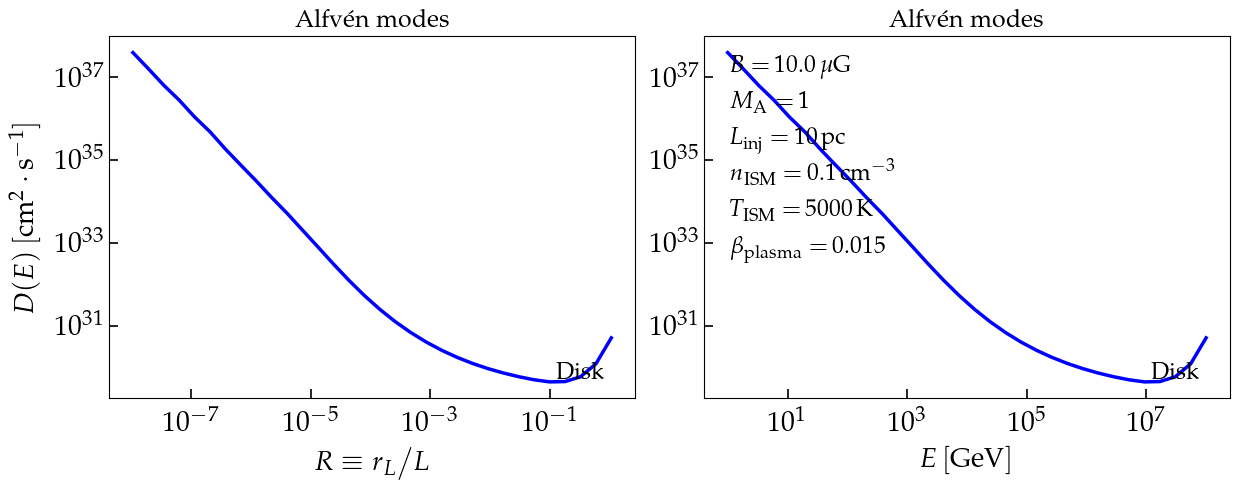

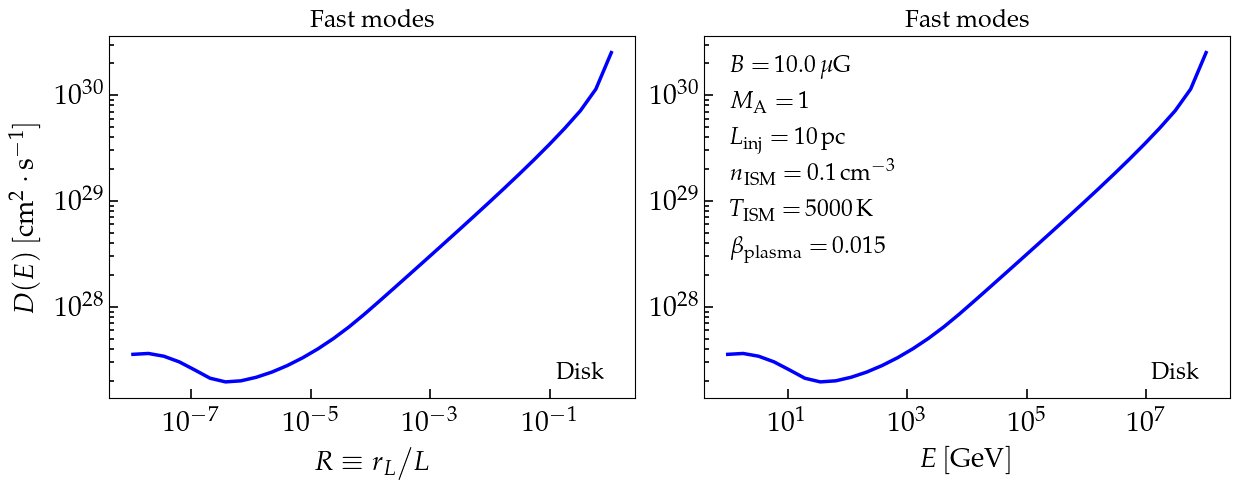

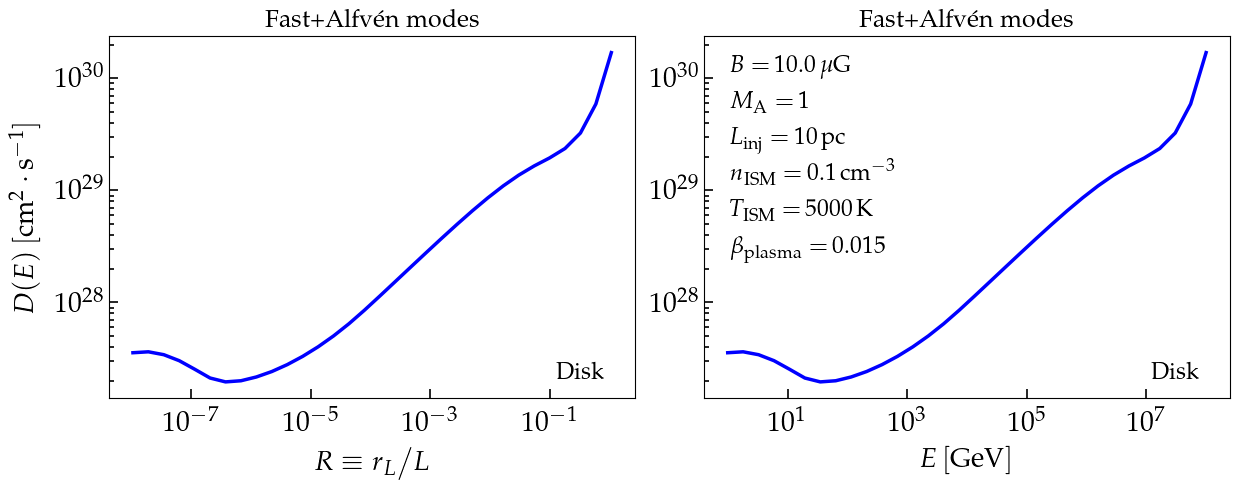

In [12]:
#######################
## Plotting the D(E) ##
#######################

print(f'The D(E) is computed in the {case_region}.')
print('')
print(f'energy points: {len(R)}')
print(f'number of points/decade in x: {pointsPerDecade}')
print(f'N_xi = {len(cosAlpha)}, xi array: [{cosAlpha[0]} -> {cosAlpha[-1]}]')
print(f'N_mu = {len(mu_array)}, mu array: [{mu_array[0]} -> {mu_array[-1]}]')


###################################
# Plotting D(E) from Alfvén modes #
###################################
plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.loglog(R, integralOverMu_Alfven, lw=2.5, color='blue')
plt.title('Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ R \equiv r_L \\big/L$',fontsize=20)
plt.ylabel('$D(E) \, [\mathrm{cm^2 \cdot s^{-1}}]$',fontsize=20)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.loglog( LarmorToMomentum(R * (L_inj*pc_cm), B_field), integralOverMu_Alfven, lw=2.5, color='blue')
plt.title('Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ E \, [\mathrm{GeV}]$',fontsize=20)
plt.text(0.05, 0.9, '$B = \,$' + str("{:.1f}".format(B_field)) + '$\, \mu \mathrm{G}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.8, '$M_\mathrm{A} = \,$' + str("{:.0f}".format(M_A)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.7, '$L_\mathrm{inj} = \,$' + str("{:.0f}".format(L_inj)) + '$\, \mathrm{pc}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.6, '$n_\mathrm{ISM} = \,$' + str("{:.1f}".format(n_ISM)) + '$\, \mathrm{cm^{-3}}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.5, '$T_\mathrm{ISM} = \,$' + str("{:.0f}".format(T_ISM)) + '$\, \mathrm{K}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.4, '$\\beta_{\mathrm{plasma}} = \,$' + str("{:.3f}".format(beta_plasma)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)
plt.tight_layout()
###################################


#################################
# Plotting D(E) from fast modes #
#################################
plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.loglog(R, integralOverMu_Fast, lw=2.5, color='blue')
plt.title('Fast modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ R \equiv r_L \\big/L$',fontsize=20)
plt.ylabel('$D(E) \, [\mathrm{cm^2 \cdot s^{-1}}]$',fontsize=20)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.loglog( LarmorToMomentum(R * (L_inj*pc_cm), B_field), integralOverMu_Fast, lw=2.5, color='blue')
plt.title('Fast modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ E \, [\mathrm{GeV}]$',fontsize=20)
plt.text(0.05, 0.9, '$B = \,$' + str("{:.1f}".format(B_field)) + '$\, \mu \mathrm{G}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.8, '$M_\mathrm{A} = \,$' + str("{:.0f}".format(M_A)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.7, '$L_\mathrm{inj} = \,$' + str("{:.0f}".format(L_inj)) + '$\, \mathrm{pc}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.6, '$n_\mathrm{ISM} = \,$' + str("{:.1f}".format(n_ISM)) + '$\, \mathrm{cm^{-3}}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.5, '$T_\mathrm{ISM} = \,$' + str("{:.0f}".format(T_ISM)) + '$\, \mathrm{K}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.4, '$\\beta_{\mathrm{plasma}} = \,$' + str("{:.3f}".format(beta_plasma)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)
plt.tight_layout()
#################################



################################
# Plotting D(E) from ALL modes #
################################
plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()


plt.loglog(R, integralOverMu_tot, lw=2.5, color='blue')
plt.title('Fast+Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ R \equiv r_L \\big/L$',fontsize=20)
plt.ylabel('$D(E) \, [\mathrm{cm^2 \cdot s^{-1}}]$',fontsize=20)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.loglog( LarmorToMomentum(R * (L_inj*pc_cm), B_field), integralOverMu_tot, lw=2.5, color='blue')
plt.title('Fast+Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ E \, [\mathrm{GeV}]$',fontsize=20)
plt.text(0.05, 0.9, '$B = \,$' + str("{:.1f}".format(B_field)) + '$\, \mu \mathrm{G}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.8, '$M_\mathrm{A} = \,$' + str("{:.0f}".format(M_A)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.7, '$L_\mathrm{inj} = \,$' + str("{:.0f}".format(L_inj)) + '$\, \mathrm{pc}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.6, '$n_\mathrm{ISM} = \,$' + str("{:.1f}".format(n_ISM)) + '$\, \mathrm{cm^{-3}}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.5, '$T_\mathrm{ISM} = \,$' + str("{:.0f}".format(T_ISM)) + '$\, \mathrm{K}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.4, '$\\beta_{\mathrm{plasma}} = \,$' + str("{:.3f}".format(beta_plasma)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.85, 0.05, str(case_region), fontsize=17, transform = plt.gca().transAxes)
plt.tight_layout()
################################


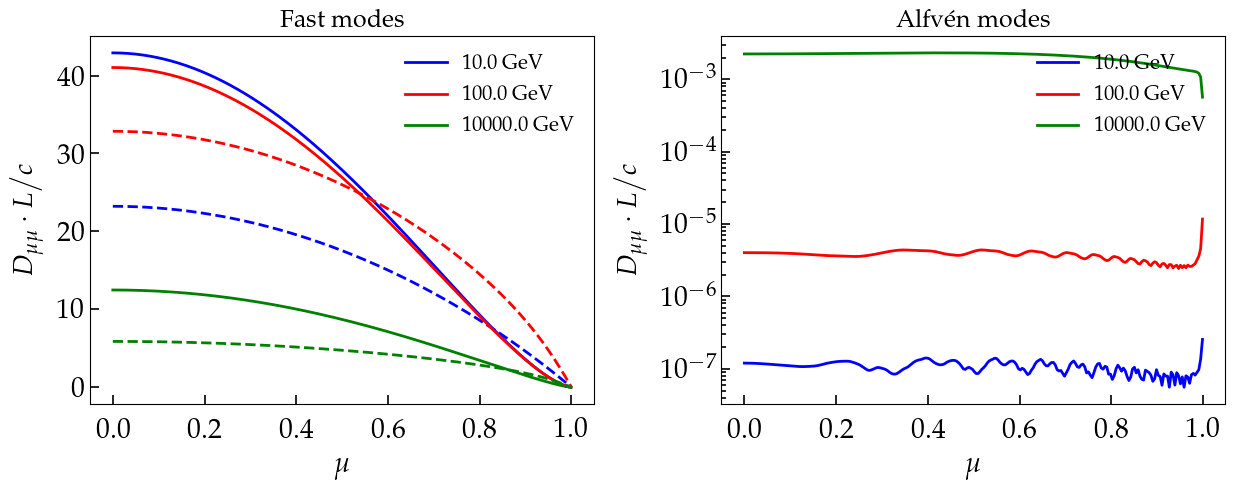

In [13]:
#########################
## Plotting the D_mumu ##
#########################

selected_p = [10., 100., 1.e4]
colors = ['blue', 'red', 'green', 'orange']
labels = [str(p) + '$\, \mathrm{GeV}$' for p in selected_p]
selected_R = [Larmor_radius(p, B_field)[1] / L_inj for p in selected_p]
indx_selR = [np.argmin( abs( ir - R ) ) for ir in selected_R]


plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

for indx_r, r in enumerate(indx_selR):
    plt.plot(mu_array, L_inj / c_pcSec * Dmumu_norm_fast_TTD[r, :], lw=2., ls='-', color=colors[indx_r], label=labels[indx_r])
    plt.plot(mu_array, L_inj / c_pcSec * Dmumu_norm_fast_Gyro[r, :], lw=2., ls='--', color=colors[indx_r])
    
plt.title('Fast modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ \\mu $',fontsize=20)
plt.ylabel('$ D_{\\mu \\mu} \cdot L\\big/c $',fontsize=20)
plt.legend(frameon=False, fontsize=15)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

for indx_r, r in enumerate(indx_selR):
    plt.plot(mu_array, L_inj / c_pcSec * Dmumu_norm_Alfven[r, :], lw=2., ls='-', color=colors[indx_r], label=labels[indx_r])

plt.title('Alfvén modes', fontsize=18, loc='center', pad=None)
plt.xlabel('$ \\mu $',fontsize=20)
plt.ylabel('$ D_{\\mu \\mu} \cdot L\\big/c $',fontsize=20)
plt.yscale('log')
plt.legend(frameon=False, fontsize=15)
plt.tight_layout()


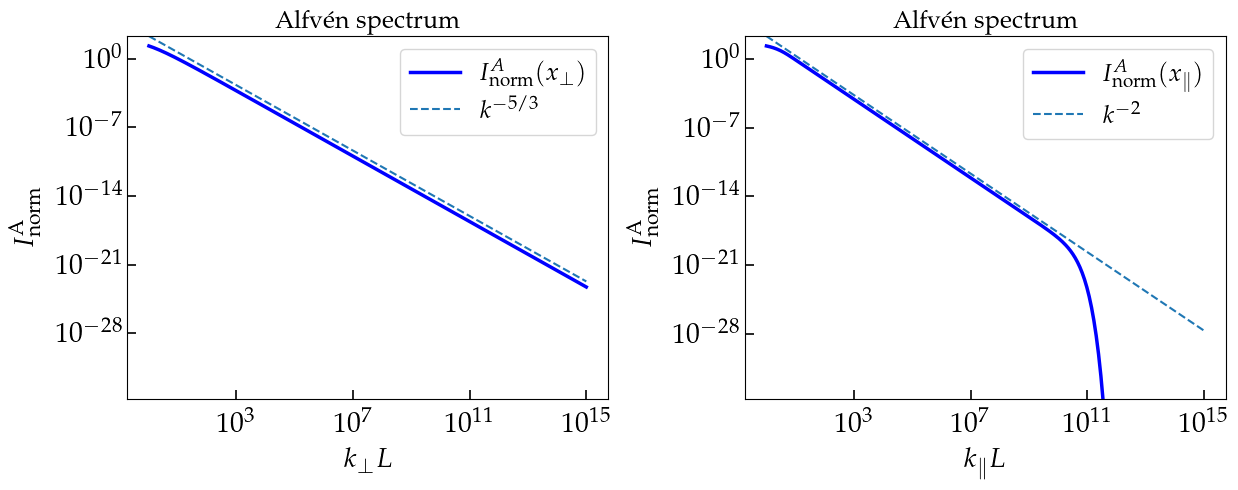

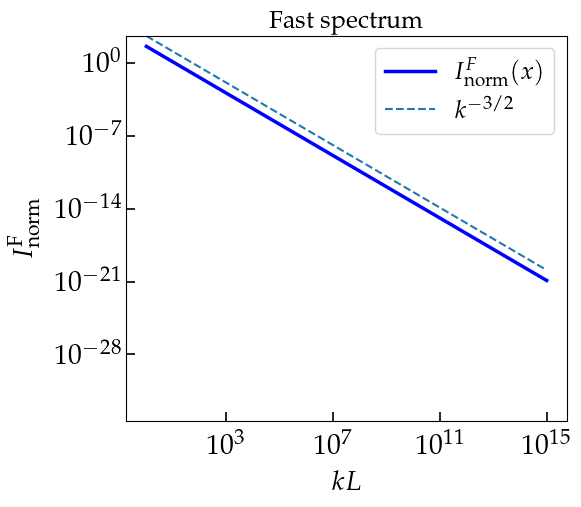

In [14]:
####################
### Plot Spectra ###
####################

specAlf_2D = np.zeros( (len(xPara_array),len(xPerp_array)) )
specFast = (x_grid**2)*fast_spectrum_norm( x_grid )

for ikprl, x_para in enumerate(xPara_array):
  for ikprp, x_perp in enumerate(xPerp_array):
    specAlf_2D[ikprl,ikprp] = xPerp_array[ikprp]*alfven_spectrum_norm( x_para, x_perp , scalings=AlfvTurbScal )

specAlf_perp = np.trapz(specAlf_2D,x=xPara_array,axis=0)
specAlf_para = np.trapz(specAlf_2D,x=xPerp_array,axis=1)

plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.loglog(xPerp_array, specAlf_perp, lw=2.5, color='blue',label=r'$I_{\rm norm}^A(x_\perp)$')
if AlfvTurbScal == 'GS95': 
  plt.loglog(xPerp_array,1.e+1*np.max(specAlf_perp)*(xPerp_array/np.min(xPerp_array))**(-5./3.),ls='--',label=r'$k^{-5/3}$')
if AlfvTurbScal == 'B06': 
  plt.loglog(xPerp_array,1.e+1*np.max(specAlf_perp)*(xPerp_array/np.min(xPerp_array))**(-3./2.),ls='--',label=r'$k^{-3/2}$')
plt.title('Alfvén spectrum', fontsize=18, loc='center', pad=None)
plt.ylim(1e-36*np.max(specAlf_perp),1.e+1*np.max(specAlf_perp))
plt.xlabel('$k_\perp L$',fontsize=20)
plt.ylabel('$I_\mathrm{norm}^\mathrm{A}$',fontsize=20)
plt.legend(fontsize=18)

plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.loglog(xPara_array, specAlf_para, lw=2.5, color='blue',label=r'$I_{\rm norm}^A(x_\parallel)$')
plt.loglog(xPara_array,1.e+1*np.max(specAlf_para)*(xPara_array/np.min(xPara_array))**(-2),ls='--',label=r'$k^{-2}$')
plt.title('Alfvén spectrum', fontsize=18, loc='center', pad=None)
plt.ylim(1e-36*np.max(specAlf_para),1.e+1*np.max(specAlf_para))
plt.xlabel('$k_\parallel L$',fontsize=20)
plt.ylabel('$I_\mathrm{norm}^\mathrm{A}$',fontsize=20)
plt.legend(fontsize=18)


plt.tight_layout()

plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.loglog(x_grid, specFast, lw=2.5, color='blue',label=r'$I_{\rm norm}^F(x)$')
plt.loglog(x_grid,1.e+1*np.max(specFast)*(x_grid/np.min(x_grid))**(-3./2.),ls='--',label=r'$k^{-3/2}$')
plt.title('Fast spectrum', fontsize=18, loc='center', pad=None)
plt.ylim(1e-36*np.max(specFast),1.e+1*np.max(specFast))
plt.xlabel('$k L$',fontsize=20)
plt.ylabel('$I_\mathrm{norm}^\mathrm{F}$',fontsize=20)
plt.legend(fontsize=18)



In [16]:
### Block to store the output D(R) in a text file ###

print(len(p_CR), len(R), len(integralOverMu_tot))
print('')

data_for_text_file_tot = np.zeros( (len(p_CR), 3) )
data_for_text_file_alfv = np.zeros( (len(p_CR), 3) )
data_for_text_file_fast = np.zeros( (len(p_CR), 3) )

data_for_text_file_tot[:,0] = p_CR
data_for_text_file_tot[:,1] = R
data_for_text_file_tot[:,2] = integralOverMu_tot

data_for_text_file_alfv[:,0] = p_CR
data_for_text_file_alfv[:,1] = R
data_for_text_file_alfv[:,2] = integralOverMu_Alfven

data_for_text_file_fast[:,0] = p_CR
data_for_text_file_fast[:,1] = R
data_for_text_file_fast[:,2] = integralOverMu_Fast

txt_file_name_tot = 'DiffCoeff_MHD' + str(L_inj) + '_MA' + str(M_A) + '_Bfield' + str(B_field) + '_Total.txt'
txt_file_name_alfv = 'DiffCoeff_MHD' + str(L_inj) + '_MA' + str(M_A) + '_Bfield' + str(B_field) + '_Alfven.txt'
txt_file_name_fast = 'DiffCoeff_MHD' + str(L_inj) + '_MA' + str(M_A) + '_Bfield' + str(B_field) + '_Fast.txt'

np.savetxt(path_plots + 'TextFiles/' + txt_file_name_tot, data_for_text_file_tot)
np.savetxt(path_plots + 'TextFiles/' + txt_file_name_alfv, data_for_text_file_alfv)
np.savetxt(path_plots + 'TextFiles/' + txt_file_name_fast, data_for_text_file_fast)


32 32 32



In [90]:
### Check Bessel functions ###

num_alpha = 100          # number of points in wave pitch-angle
#
length_mu_array = 100    # number of points in CR pitch-angle array
mu_array_min = 0.        # min value of CR pitch-angle array
mu_array_max = 0.999     # max value of CR pitch-angle array (warning: mu=1 is singular)
#
max_kL = 1e+9        # max k*L value used to compute spectra
pointsPerDecade = 10  # for the integrals over the turbulence
#
log_p_CR_min = 2   # min p_CR in log-scale [GeV/c]
log_p_CR_max = 6   # max p_CR in log-scale [GeV/c]
num_log_p_CR = 8  # number of points in p_CR (equally spaced in log-scale)

cosAlpha = np.linspace(start = 0., stop = 1., num = num_alpha)  # array with the cosine of the wave pitch-angle (= k_para/k = xi)
#
mu_array = np.linspace(start=mu_array_min, stop=mu_array_max, num=length_mu_array)   # array with the CR pitch-angle
#
xPara_array = np.logspace(start=0, stop=np.log10( max_kL ), num=pointsPerDecade*round(np.log10(max_kL)) )   # x_para = k_para*L
if (M_A <= 1.):
  xPerp_array = np.logspace(start=np.log10(M_A**(-2.)), stop=np.log10(max_kL), num = pointsPerDecade*round(np.log10(max_kL)) )  # x_perp = k_perp*L
else:
  xPerp_array = np.logspace(start=np.log10(M_A**3), stop=np.log10(max_kL), num=pointsPerDecade*round(np.log10( max_kL)) )
if case_region == 'Halo':
  n_decades = round( np.log10( kmaxL_coll_xi(csi) ) )
  x_grid = np.logspace(start=0., stop=np.log10( kmaxL_coll_xi(csi) ), num=n_decades*pointsPerDecade)    
elif case_region == 'Disk':
  n_decades = round( np.log10( min( kmaxL_visc_xi(csi), kmaxL_coll_xi(csi) ) ) )
  x_grid = np.logspace(start=0., stop=np.log10( min( kmaxL_visc_xi(csi), kmaxL_coll_xi(csi) ) ), num=n_decades*pointsPerDecade)
#
p_CR = np.logspace(start=log_p_CR_min,stop=log_p_CR_max, num=num_log_p_CR)  # array with the CR momentum in GeV/c    
R = Larmor_radius(p_CR, B_field)[1] / L_inj
    

J_FastTTD = np.zeros((len(R),len(x_grid),len(cosAlpha),len(mu_array)))
J_FastGyro = np.zeros((len(R),len(x_grid),len(cosAlpha),len(mu_array)))

J_AlfvGyro = np.zeros((len(R),len(xPerp_array),len(mu_array)))

for indx_mu, mu in enumerate(tqdm(mu_array)):
  for indx_csi, csi in enumerate(cosAlpha):
    for indx_x, x  in enumerate(x_grid):
      for indx_R, r in enumerate(R):  
        J_FastTTD[indx_R,indx_x,indx_csi,indx_mu] =  ( bessel.jv( 1, Bessel_argFast(r, x, csi, mu) ) )**2  
        J_FastGyro[indx_R,indx_x,indx_csi,indx_mu] = ( ( bessel.jv( 0, Bessel_argFast(r, x, csi, mu) ) - bessel.jv( 2, Bessel_argFast(r, x, csi, mu) ) ) / 2. )**2

for indx_mu, mu in enumerate(tqdm(mu_array)):
  for indx_xprp, xprp  in enumerate(xPerp_array):
    for indx_R, r in enumerate(R): 
      J_AlfvGyro[indx_R,indx_xprp,indx_mu] = ( bessel.jv( 1, Bessel_argAlf(r, xprp, mu) ) / Bessel_argAlf(r, xprp, mu) )**2   



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

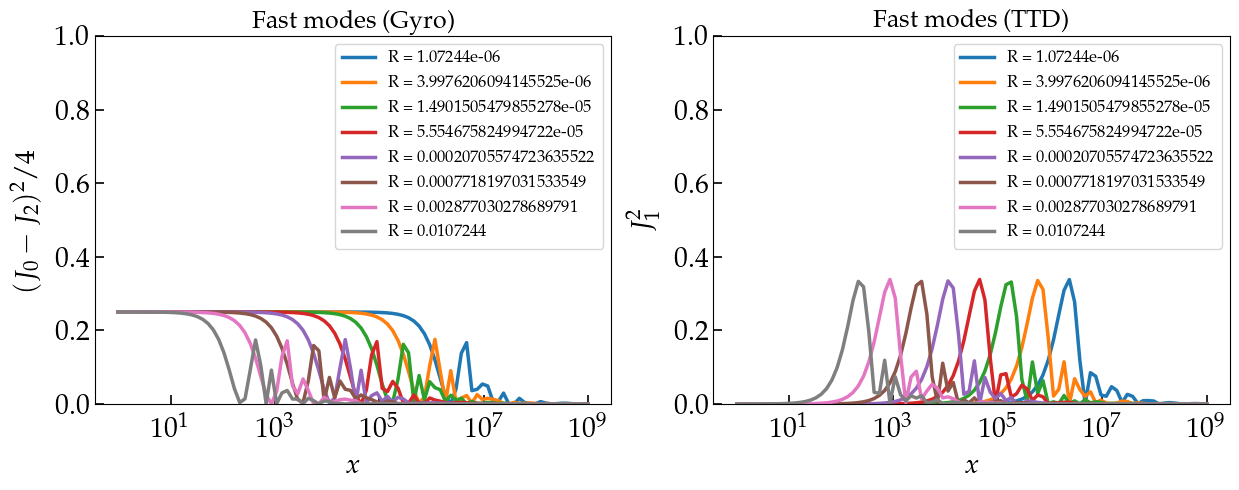

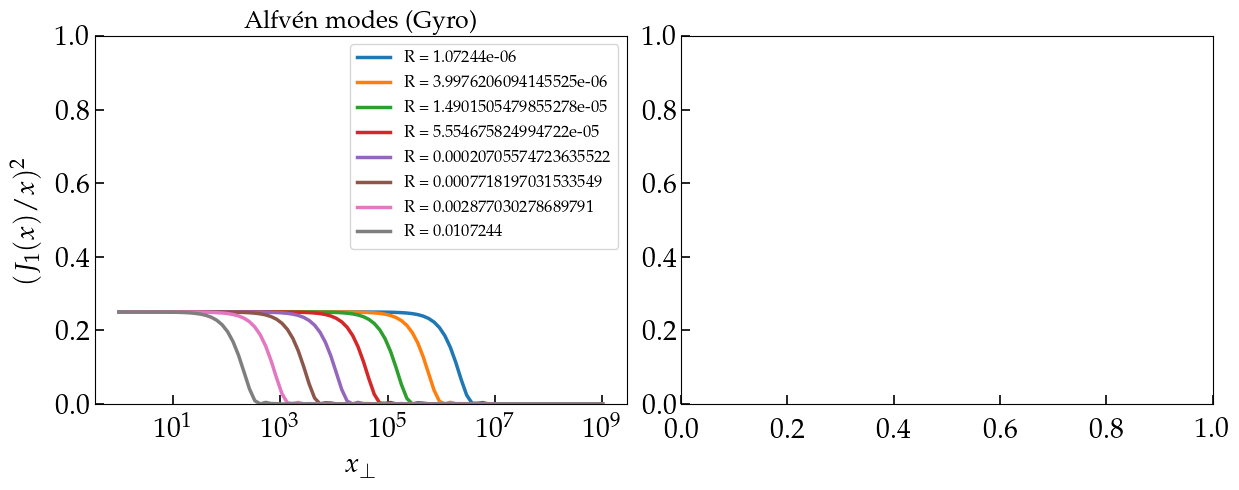

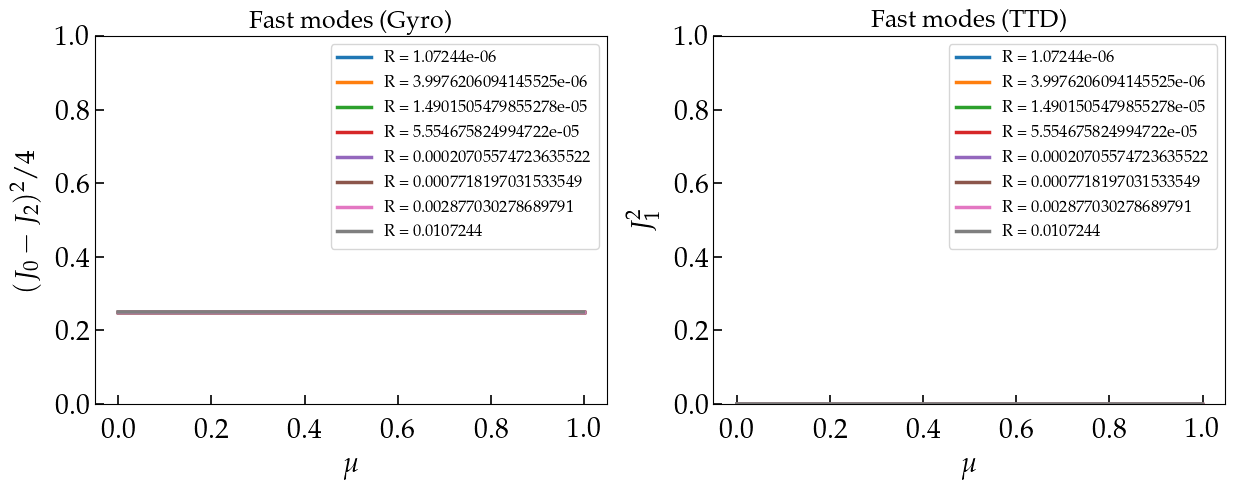

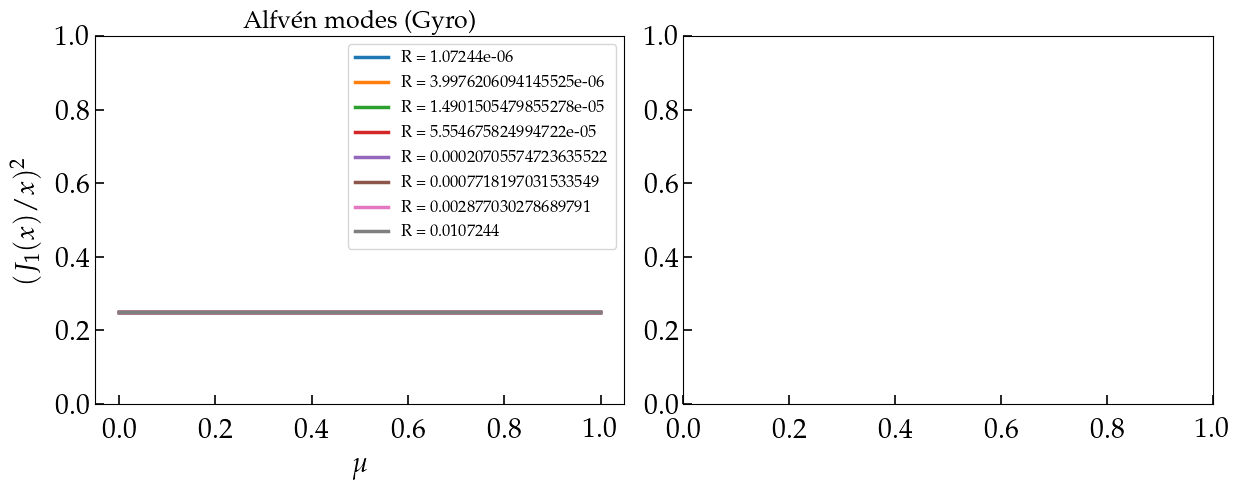

In [114]:
R0 = 1e-2
xi0 = 0.5
mu0 = 0.5

x0 = 1e+8 #1./R0

ind_xi0 = np.where(cosAlpha >= xi0)[0][0]
ind_mu0 = np.where(mu_array >= mu0)[0][0]
ind_R0 = np.where(R >= R0)[0][0]
ind_x0 = np.where(x >= x0)[0][0]
ind_xprp0 = np.where(xprp >= x0)[0][0]

plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

for ir,r in enumerate(R):
  plt.plot(x_grid, J_FastGyro[ir,:,ind_xi0,ind_mu0], lw=2.5, label=f'R = {r}')
plt.title('Fast modes (Gyro)', fontsize=18, loc='center', pad=None)
plt.ylim(0.,1.)
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$(J_0-J_2)^2/4$',fontsize=20)
plt.xscale('log')
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plot_cosmetics_multi()

for ir,r in enumerate(R):
  plt.plot(x_grid, J_FastTTD[ir,:,ind_xi0,ind_mu0], lw=2.5, label=f'R = {r}')
plt.title('Fast modes (TTD)', fontsize=18, loc='center', pad=None)
plt.ylim(0.,1.)
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$J_1^2$',fontsize=20)
plt.xscale('log')
plt.legend(fontsize=12)

plt.tight_layout()

plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

for ir,r in enumerate(R):
  plt.plot(xPerp_array, J_AlfvGyro[ir,:,ind_mu0], lw=2.5, label=f'R = {r}')
plt.title('Alfvén modes (Gyro)', fontsize=18, loc='center', pad=None)
plt.ylim(0.,1.)
plt.xlabel(r'$x_\perp$',fontsize=20)
plt.ylabel(r'$(J_1(x)/x)^2$',fontsize=20)
plt.xscale('log')
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.tight_layout()




plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

for ir,r in enumerate(R):
  plt.plot(mu_array, J_FastGyro[ir,ind_x0,ind_xi0,:], lw=2.5, label=f'R = {r}')
plt.title('Fast modes (Gyro)', fontsize=18, loc='center', pad=None)
plt.ylim(0.,1.)
plt.xlabel(r'$\mu$',fontsize=20)
plt.ylabel(r'$(J_0-J_2)^2/4$',fontsize=20)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plot_cosmetics_multi()

for ir,r in enumerate(R):
  plt.plot(mu_array, J_FastTTD[ir,ind_x0,ind_xi0,:], lw=2.5, label=f'R = {r}')
plt.title('Fast modes (TTD)', fontsize=18, loc='center', pad=None)
plt.ylim(0.,1.)
plt.xlabel(r'$\mu$',fontsize=20)
plt.ylabel(r'$J_1^2$',fontsize=20)
plt.legend(fontsize=12)

plt.tight_layout()

plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()

for ir,r in enumerate(R):
  plt.plot(mu_array, J_AlfvGyro[ir,ind_xprp0,:], lw=2.5, label=f'R = {r}')
plt.title('Alfvén modes (Gyro)', fontsize=18, loc='center', pad=None)
plt.ylim(0.,1.)
plt.xlabel(r'$\mu$',fontsize=20)
plt.ylabel(r'$(J_1(x)/x)^2$',fontsize=20)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plot_cosmetics_multi()


plt.tight_layout()

50 50
